# Advanced Lane Finding Project

## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


[//]: # (Image References)

[image1]: ./output_images/camera_calibration.jpg "Undistorted Chessfield"
[image2]: ./output_images/undistorted_test_image.jpg "Undistorted test image"

[video1]: ./project_video.mp4 "Video"


---

### Camera Calibration

The code for this step is contained in the first code cell of the IPython notebook located in "./lanefinding.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. The camera matrix and the distortion coefficients are stored in "cameraCorrection.p" with pickle.

I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]


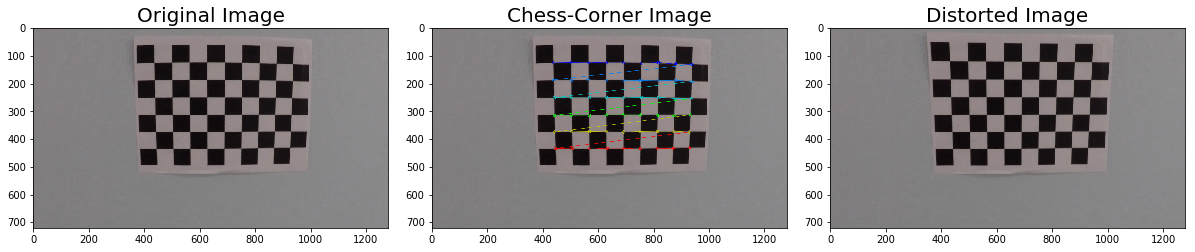

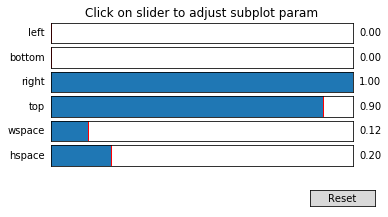

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import random

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #cornerimg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #new_name = './output_images/cc_drawCorners_' + fname.split('\\')[-1]
        #cv2.imwrite(new_name,cornerimg)

retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save camera calibration data 
dist_pickle = {}
dist_pickle["mtx"] = cameraMatrix
dist_pickle["dist"] = distCoeffs
pickle.dump( dist_pickle, open( "./cameraCorrection.p", "wb" ) )


# Plot and save the process of undistortion of random image
randIndex = random.randint(0,len(images))
original = cv2.imread(images[randIndex])
imgtemp = cv2.imread(images[randIndex])
gray = cv2.cvtColor(imgtemp,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
# Draw and display the corners
drawChessImg = cv2.drawChessboardCorners(imgtemp, (9,6), corners, ret)
cv2.imwrite('./output_images/chess_drawCorners.jpg', drawChessImg)
distimg = cv2.undistort(original, cameraMatrix, distCoeffs, None, cameraMatrix)
cv2.imwrite('./output_images/chess_undistored.jpg', distimg)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 96))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(drawChessImg)
ax2.set_title('Chess-Corner Image', fontsize=20)
ax3.imshow(distimg)
ax3.set_title('Distorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.subplot_tool()
plt.show()

---
[//]: # (Image References)
[image2]: ./output_images/undistorted_test_image.jpg "Undistorted test image"

### Pipeline (single images) 

#### Image distortion-correction
By using the stored camera correction coefficients, the images will be undistorted.

![alt text][image2]

#### Create thresholded binary image

#### Perform a perspective transform

#### Identify lane-line pixels

#### Calculate the radius of curvatur and car position

#### Plot the identified lane



In [2]:
import cv2
import numpy as np

# Image distortion-correction
def undistort_image(img, cameraMatrix, distCoeffs):
    return cv2.undistort(img, cameraMatrix,distCoeffs, None, cameraMatrix)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your dir_binary image
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    hls_binary = np.zeros_like(hls[:, :, 2])
    hls_binary[(hls[:, :, 2] > thresh[0]) & (hls[:, :, 2]<= thresh[1])] = 1
    return hls_binary


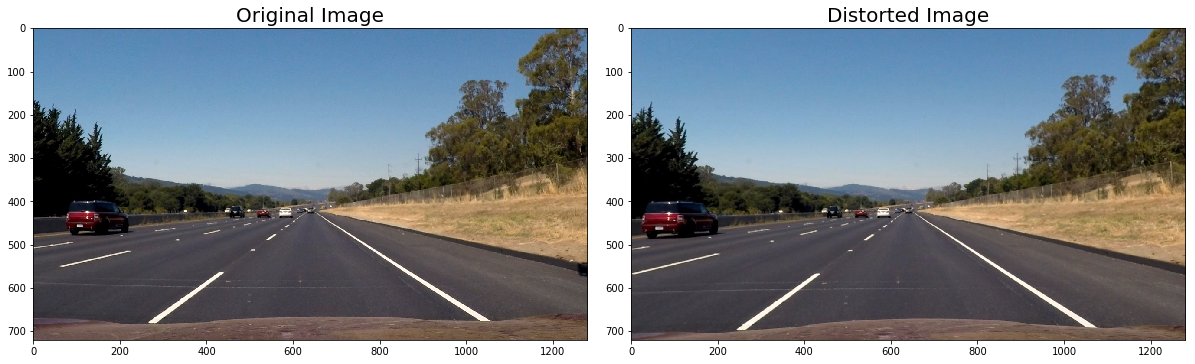

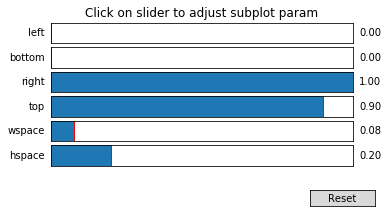

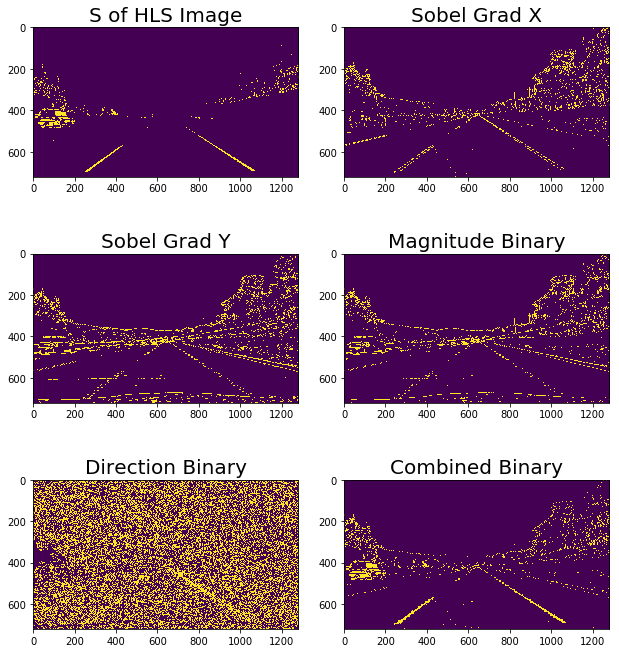

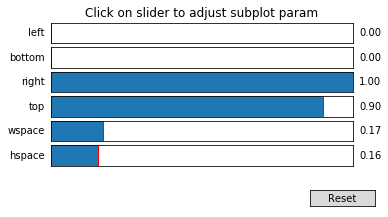

In [13]:
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pickle
import random

#load camera matrix and dist coefficients
calib_dist = pickle.load(open("./cameraCorrection.p","rb"))
mtx = calib_dist["mtx"]
dist = calib_dist["dist"]



# Make a list of calibration images
images = glob.glob('test_images/*.jpg')
randIndex = random.randint(0,len(images)-1)
img = cv2.imread(images[randIndex])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
distimg = undistort_image(img_rgb, mtx, dist)

# Plot and save undistorted test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 64))
f.tight_layout()
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(distimg)
ax2.set_title('Distorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.subplot_tool()
plt.show()


# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(distimg, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady = abs_sobel_thresh(distimg, orient='y', sobel_kernel=ksize, thresh=(20,100))
mag_binary = mag_thresh(distimg, sobel_kernel=ksize, mag_thresh=(30,100))
dir_binary = dir_threshold(distimg, sobel_kernel=ksize, thresh=(0.7, 1.3))
s_binary = hls_select(distimg, thresh=(170, 255))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1

# Plot and save color and gradient transformation
cv2.imwrite('./output_images/test_image_undistored.jpg', distimg)
cv2.imwrite('./output_images/test_image_gradx.jpg', gradx)
cv2.imwrite('./output_images/test_image_grady.jpg', grady)
cv2.imwrite('./output_images/test_image_mag_binary.jpg', mag_binary)
cv2.imwrite('./output_images/test_image_dir_binary.jpg', dir_binary)
cv2.imwrite('./output_images/test_image_hls_s_binary.jpg', s_binary)
cv2.imwrite('./output_images/test_image_combined.jpg', combined)

f, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(8, 10))
f.tight_layout()
ax1.imshow(s_binary)
ax1.set_title('S of HLS Image', fontsize=20)
ax2.imshow(gradx)
ax2.set_title('Sobel Grad X', fontsize=20)
ax3.imshow(grady)
ax3.set_title('Sobel Grad Y', fontsize=20)
ax4.imshow(mag_binary)
ax4.set_title('Magnitude Binary', fontsize=20)
ax5.imshow(dir_binary)
ax5.set_title('Direction Binary', fontsize=20)
ax6.imshow(combined)
ax6.set_title('Combined Binary', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.subplot_tool()
plt.show()



---

### Pipeline (video) 

